## **Pratical work – implementation of two optical flow methods** ##



Student 1 : Diez Marie

Student 2 : Tosato Lucrezia

You need to execute your code in the directory python, the data path should start as "../data/"

In [ ]:
!wget --no-check-certificate "https://pequan.lip6.fr/~bereziat/cours/master/vision/vision-2021-of-data.tgz"
!tar xvzf vision-2021-of-data.tgz

--2022-01-24 13:21:55--  https://pequan.lip6.fr/~bereziat/cours/master/vision/vision-2021-of-data.tgz
Resolving pequan.lip6.fr (pequan.lip6.fr)... 132.227.74.4
Connecting to pequan.lip6.fr (pequan.lip6.fr)|132.227.74.4|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3861293 (3.7M) [application/x-gzip]
Saving to: ‘vision-2021-of-data.tgz’

vision-2021-of-data 100%[===================>]   3.68M  1.66MB/s    in 2.2s    

2022-01-24 13:21:58 (1.66 MB/s) - ‘vision-2021-of-data.tgz’ saved [3861293/3861293]

data/mysine/correct_mysine.png
data/mysine/mysine10.png
data/mysine/mysine9.png
data/mysine/._mysine_horn.png
data/mysine/mysine_horn.png
data/mysine/._mysine_lucas.png
data/mysine/mysine_lucas.png
data/nasa/nasa10.png
data/nasa/nasa9.png
data/nasa/._nasa_horn.png
data/nasa/nasa_horn.png
data/nasa/._nasa_lucas.png
data/nasa/nasa_lucas.png
data/rubberwhale/._correct_rubberwhale10.png
data/rubberwhale/correct_rubbe

In [ ]:
%cd /content/python
!pwd

/content/python
/content/python


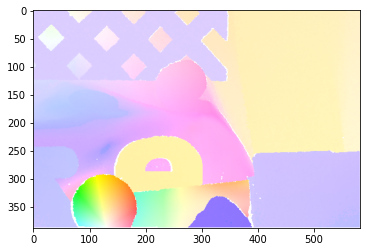

<Figure size 640x480 with 1 Axes>


In [ ]:
%run "middlebury.py"
import tqdm.notebook as tq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage.filters import convolve
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy import misc

!python middlebury.py

In [ ]:
def gradhorn(I1,I2):
    """
    Compute the gradients
    """
    Ix = np.zeros((I1.shape))
    Iy = np.zeros((I1.shape))
    It = np.zeros((I1.shape))
    
    for i in range(I1.shape[0]):
        for j in range(I1.shape[1]):
            if i+1 < I1.shape[0] and j+1 < I1.shape[1]:
                Ix[i,j] = I1[i,j+1] - I1[i,j] + I1[i+1,j+1] - I1[i+1,j] + I2[i,j+1] - I2[i,j] + I2[i+1,j+1] - I2[i+1,j]
                Iy[i,j] = I1[i+1,j] - I1[i,j] + I1[i+1,j+1] - I1[i,j+1] + I2[i+1,j] - I2[i,j] + I2[i+1,j+1] - I2[i,j+1]
                It[i,j] = I2[i,j] - I1[i,j] + I2[i+1,j] - I1[i+1,j] + I2[i,j+1] - I1[i,j+1] + I2[i+1,j+1] - I1[i+1,j+1] 
    return 1/4*Ix, 1/4*Iy, 1/4*It
    
def horn(I1,I2,alpha,N):
    """
    Horn function
    """
    I1 = cv2.imread(I1, 0).astype(np.float32)
    I2 = cv2.imread(I2, 0).astype(np.float32)
    Ix, Iy, It = gradhorn(I1, I2)
    A = np.matrix([[1/12, 1/6, 1/12],  [1/6, 0, 1/6], [1/12, 1/6, 1/12]])

    u_0 = np.zeros([I1.shape[0],I1.shape[1]])
    v_0 = np.zeros([I1.shape[0],I1.shape[1]])

    u_k = u_0
    v_k = v_0
    for k in range(0, N-1):
        u_bar_k = convolve(u_k, A)
        v_bar_k = convolve(v_k, A)
        
        supp = ( ( Ix*u_bar_k ) + ( Iy*v_bar_k ) + It )
        inf = alpha + Ix**2 + Iy**2
        derivatives = np.divide(supp, inf)

        u_k = u_bar_k - Ix * derivatives
        v_k = v_bar_k - Iy * derivatives
    
    w = np.zeros([ I1.shape[0], I1.shape[1], 2 ])
    w[: , : , 0] = u_k
    w[: , : , 1] = v_k
    return w

""" Errors functions """
def err_ang_f(REF, HS):
    supp = 1 + np.array(REF[:,:,0])*(np.array(HS[:,:,0])) + np.array(REF[:,:,1])*(np.array(HS[:,:,1]))
    inf = (np.sqrt( 1+(REF[:,:,0])**2 + (REF[:,:,1])**2))*(np.sqrt( 1 + (HS[:,:,0])**2 + (HS[:,:,1])**2))
    cos = np.rad2deg(np.arccos(np.round(supp/inf, 6)))
    return np.mean(cos), np.std(cos)
  
def err_norm_f(REF, HS):
    norm = np.abs(REF)-np.abs(HS)
    return norm.mean(), norm.std()

def err_epe_f(REF, HS):
    dist= np.abs(REF-HS)
    return dist.mean(), dist.std()

def optimize_horn_schunck(I1, I2, REF, min_alpha=1, max_alpha=100, N=100, alpha0=None, optim=1):
    """ Optimisation of the parameter alpha for horn shunck """
    best_err_ang_mean = -1
    best_err_ang_std = -1
    best_err_norm_mean = -1
    best_err_norm_std = -1
    best_err_epe_mean = -1
    best_err_epe_std = -1
    best_alpha = -1
    
    best_N = 0
    X = []
    Y = []
    if alpha0!= None:
      HS = horn(I1, I2, alpha0, N)
      err_ang_mean, err_ang_std= err_ang_f(REF, HS)
      err_norm_mean, err_norm_std = err_norm_f(REF, HS)
      err_epe_mean, err_epe_std = err_epe_f(REF, HS)

      print("Best ang error mean : {} std : {}".format( err_ang_mean, err_ang_std))
      print("Best norm error mean : {} std : {}".format( err_norm_mean, err_norm_std))
      print("Best epe error  mean : {} std : {}".format( err_epe_mean, err_epe_std))
      return alpha0
    
    if optim == 1:
      label = 'Angular error'
    if optim == 2:
      label = 'Norm error'
    if optim == 3:
      label = 'EPE error'

    for alpha in tq.tqdm(range(min_alpha, max_alpha)):
        HS = horn(I1, I2, alpha, N)
        err_ang_mean, err_ang_std= err_ang_f(REF, HS)
        err_norm_mean, err_norm_std = err_norm_f(REF, HS)
        err_epe_mean, err_epe_std = err_epe_f(REF, HS)
        
        X.append(alpha)
        if optim == 1:
          Y.append(err_ang_mean)
        if optim == 2:
          Y.append(err_norm_mean)
        if optim == 3:
          Y.append(err_epe_mean)
        if err_ang_mean<best_err_ang_mean or best_err_ang_mean==-1:
            best_err_ang_mean = err_ang_mean
            best_err_ang_std = err_ang_std
            if optim == 1:
              best_alpha = alpha
        
        if err_norm_mean<best_err_norm_mean or best_err_norm_mean==-1:
            best_err_norm_mean = err_norm_mean
            best_err_norm_std = err_norm_std
            if optim == 2:
              best_alpha = alpha
        if err_epe_mean < best_err_epe_mean or best_err_epe_mean==-1:
            best_err_epe_mean = err_epe_mean
            best_err_epe_std = err_epe_std
            if optim == 3:
              best_alpha = alpha
            
    ax = sns.relplot(x=X, y=Y, kind="line")
    ax.set(xlabel='Alpha', ylabel=label)
    plt.title("Optimization result with N ="+str(N))
    plt.show()
    print("Best ang error mean : {} std : {}".format( best_err_ang_mean, best_err_ang_std))
    print("Best norm error mean : {} std : {}".format( best_err_norm_mean, best_err_norm_std))
    print("Best epe error  mean : {} std : {}".format( best_err_epe_mean, best_err_epe_std))
    return best_alpha

def quiver(flow, title, step=5, inv=True):
    """quiver function """
    if inv :
        plt.title(title)
        plt.quiver(np.arange(0, flow.shape[1], step), -np.arange(flow.shape[0], 0, -step), 
                   flow[::step, ::step, 0], -flow[::step, ::step, 1])
        plt.show()
    else:
        plt.title(title)
        plt.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0], 0, -step), 
                   flow[::step, ::step, 0], -flow[::step, ::step, 1])
        plt.show()
        
def lucas(I1,I2,n):
    """ Lucas-Kanade function """
    I1 = cv2.imread(I1, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    I2 = cv2.imread(I2, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    Ix, Iy, It = gradhorn(I1, I2)
    w = int(n/2)
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in range(w,I1.shape[0]-w):
        for j in range(w,I1.shape[1]-w):
            fx = Ix[i-w:i+w+1,j-w:j+w+1].flatten()
            fy = Iy[i-w:i+w+1,j-w:j+w+1].flatten()
            ft = It[i-w:i+w+1,j-w:j+w+1].flatten()
            b = np.reshape(-ft, (ft.shape[0],1))
            A = np.vstack((fx, fy)).T
            eye = np.eye((A.T.dot(A).shape[0]))
            w_vect_int = np.linalg.lstsq(A.T.dot(A),eye)[0]
            w_vect = w_vect_int.dot(A.T).dot(b) # lstq
            u[i,j] = w_vect[0]
            v[i,j] = w_vect[1]
    return u,v

def lucasG(I1,I2,n, sigma):
    """ Lucas-Kanade function with gaussian window """
    I1 = cv2.imread(I1, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    I2 = cv2.imread(I2, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    Ix, Iy, It = gradhorn(I1, I2)
    Ix = gaussian_filter(Ix, sigma=sigma)
    Iy = gaussian_filter(Iy, sigma=sigma)
    It = gaussian_filter(It, sigma=sigma)

    w = int(n/2)
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)

    for i in range(w,I1.shape[0]-w):
        for j in range(w,I1.shape[1]-w):
            fx = Ix[i-w:i+w+1,j-w:j+w+1].flatten()
            fy = Iy[i-w:i+w+1,j-w:j+w+1].flatten()
            ft = It[i-w:i+w+1,j-w:j+w+1].flatten()
            b = np.reshape(-ft, (ft.shape[0],1))
            A = np.vstack((fx, fy)).T
            eye = np.eye((A.T.dot(A).shape[0]))
            w_vect_int = np.linalg.lstsq(A.T.dot(A),eye)[0]
            w_vect = w_vect_int.dot(A.T).dot(b) # lstq
            u[i,j] = w_vect[0]
            v[i,j] = w_vect[1]
    return u,v

""" no useful anymore 
def adjust_ref_to_w(REF, ws):
    REF_ = REF.copy()
    REF_[0:ws//2, :] = 0
    REF_[:,0:ws//2] = 0
    REF_[REF_.shape[0]-ws//2:REF_.shape[0], :]=0
    REF_[:, REF_.shape[1]-ws//2:REF_.shape[1]]=0
    return REF_
"""

def optimize_kanade(I1, I2, REF0, min_size=1, max_size=50,ws0=None, sigma=None,optim=1):
    """ Optimisation of the parameter windows size : ws for lucas-kanade """
    best_err_ang_mean = -1
    best_err_ang_std = -1
    best_err_norm_mean = -1
    best_err_norm_std = -1
    best_err_epe_mean = -1
    best_err_epe_std = -1
    best_alpha = -1
    best_wind_size= -1
    best_REF = REF0.copy()
    
    if ws0 != None:
        u,v= lucas(I1,I2,ws0)
        u_exp = np.expand_dims(u, axis=2)
        v_exp = np.expand_dims(v, axis=2)
        w =np.concatenate((u_exp,v_exp), axis=2) 
        
        err_ang_mean, err_ang_std= err_ang_f(REF0, w)
        err_norm_mean, err_norm_std = err_norm_f(REF0, w)
        err_epe_mean, err_epe_std = err_epe_f(REF0, w)
        
        print("Best ang error mean : {} std : {}".format( err_ang_mean, err_ang_std))
        print("Best norm error mean : {} std : {}".format( err_norm_mean, err_norm_std))
        print("Best epe error  mean : {} std : {}".format( err_epe_mean, err_epe_std))
        return ws0, REF0
    
    X = []
    Y = []
    if optim == 1:
      label = 'Angular error'
    if optim == 2:
      label = 'Norm error'
    if optim == 3:
      label = 'EPE error'

    for ws in tq.tqdm(range(min_size, max_size, 2)):
        if sigma == None:
          u,v= lucas(I1,I2,ws)
        else:
          u,v= lucasG(I1,I2,ws, sigma)
        u_exp = np.expand_dims(u, axis=2)
        v_exp = np.expand_dims(v, axis=2)
        w =np.concatenate((u_exp,v_exp), axis=2) 
        
        err_ang_mean, err_ang_std= err_ang_f(REF0, w)
        err_norm_mean, err_norm_std = err_norm_f(REF0, w)
        err_epe_mean, err_epe_std = err_epe_f(REF0, w)

        X.append(ws)
        if optim == 1:
          Y.append(err_ang_mean)
        if optim == 2:
          Y.append(err_norm_mean)
        if optim == 3:
          Y.append(err_epe_mean)
        if err_ang_mean<best_err_ang_mean or best_err_ang_mean==-1:
            best_err_ang_mean = err_ang_mean
            best_err_ang_std = err_ang_std
            if optim == 1:
              best_wind_size = ws
              best_REF = REF0
              label = 'Angular error'

        if err_norm_mean<best_err_norm_mean or best_err_norm_mean==-1:
            best_err_norm_mean = err_norm_mean
            best_err_norm_std = err_norm_std
            if optim == 2:
              best_wind_size = ws
              best_REF = REF0
              label = 'Norm error'

        if err_epe_mean < best_err_epe_mean or best_err_epe_mean==-1:
            best_err_epe_mean = err_epe_mean
            best_err_epe_std = err_epe_std
            if optim == 3:
              best_wind_size = ws
              best_REF = REF0
              label = 'EPE error'

    ax = sns.relplot(x=X, y=Y, kind="line")
    ax.set(xlabel='Windows size', ylabel=label)
    plt.show()
    
    print("Best ang error mean : {} std : {}".format( best_err_ang_mean, best_err_ang_std))
    print("Best norm error mean : {} std : {}".format( best_err_norm_mean, best_err_norm_std))
    print("Best epe error  mean : {} std : {}".format( best_err_epe_mean, best_err_epe_std))
    return best_wind_size

def optimize_kanade_sigma(I1, I2, REF0, min_size=1, max_size=50,ws0=None, sigma_min=1, sigma_max=5, optim=1):
    """ Optimisation of the parameter windows size : ws and the parameter sigma for lucas-kanade """
    best_err_ang_mean = -1
    best_err_ang_std = -1
    best_err_norm_mean = -1
    best_err_norm_std = -1
    best_err_epe_mean = -1
    best_err_epe_std = -1
    best_alpha = -1
    best_wind_size= -1
    best_sigma = -1
    best_REF = REF0.copy()
    
    if ws0 != None:
        u,v= lucas(I1,I2,ws0)
        u_exp = np.expand_dims(u, axis=2)
        v_exp = np.expand_dims(v, axis=2)
        w =np.concatenate((u_exp,v_exp), axis=2) 
        
        err_ang_mean, err_ang_std= err_ang_f(REF0, w)
        err_norm_mean, err_norm_std = err_norm_f(REF0, w)
        err_epe_mean, err_epe_std = err_epe_f(REF0, w)
        
        print("Best ang error mean : {} std : {}".format( err_ang_mean, err_ang_std))
        print("Best norm error mean : {} std : {}".format( err_norm_mean, err_norm_std))
        print("Best epe error  mean : {} std : {}".format( err_epe_mean, err_epe_std))
    
        return ws0, REF0
    
    X = []
    Y = []
    if optim == 1:
      label = 'Angular error'
    if optim == 2:
      label = 'Norm error'
    if optim == 3:
      label = 'EPE error'
    for ws in tq.tqdm(range(min_size, max_size, 2)):
      for sig in tq.tqdm(range(sigma_min, sigma_max, 1)):
        u,v= lucasG(I1,I2,ws, sig)
        u_exp = np.expand_dims(u, axis=2)
        v_exp = np.expand_dims(v, axis=2)
        w =np.concatenate((u_exp,v_exp), axis=2) 
        
        err_ang_mean, err_ang_std= err_ang_f(REF0, w)
        err_norm_mean, err_norm_std = err_norm_f(REF0, w)
        err_epe_mean, err_epe_std = err_epe_f(REF0, w)

        X.append(ws)
        if optim == 1:
          Y.append(err_ang_mean)
        if optim == 2:
          Y.append(err_norm_mean)
        if optim == 3:
          Y.append(err_epe_mean)
          
        if err_ang_mean<best_err_ang_mean or best_err_ang_mean==-1:
            best_err_ang_mean = err_ang_mean
            best_err_ang_std = err_ang_std
            if optim == 1:
              best_wind_size = ws
              best_REF = REF0
              best_sigma = sig

        if err_norm_mean<best_err_norm_mean or best_err_norm_mean==-1:
            best_err_norm_mean = err_norm_mean
            best_err_norm_std = err_norm_std
            if optim == 2:
              best_wind_size = ws
              best_REF = REF0
              best_sigma = sig

        if err_epe_mean < best_err_epe_mean or best_err_epe_mean==-1:
            best_err_epe_mean = err_epe_mean
            best_err_epe_std = err_epe_std
            if optim == 3:
              best_wind_size = ws
              best_REF = REF0
              best_sigma = sig


    ax = sns.relplot(x=X, y=Y, kind="line")
    ax.set(xlabel='Windows size, best sigma = {}'.format(best_sigma), ylabel=label)
    plt.show()

    print("best sigma : ", best_sigma)
    print("Best ang error mean : {} std : {}".format( best_err_ang_mean, best_err_ang_std))
    print("Best norm error mean : {} std : {}".format( best_err_norm_mean, best_err_norm_std))
    print("Best epe error  mean : {} std : {}".format( best_err_epe_mean, best_err_epe_std))
    return best_wind_size, best_sigma


def run_horn(I1, I2, REF, step=5, N=100, max_alpha=700, color=True, inv=True, alpha0=None, optim=1):
    """ Run horn function with optimisation """
    alpha = optimize_horn_schunck(I1, I2, REF, max_alpha=max_alpha, alpha0=alpha0, optim=optim)
    print("Best alpha  = "+str(alpha))
    HS = horn(I1, I2, alpha, N)
    
    plt.imshow(computeColor(REF.copy(), color))
    plt.title('Reference')
    plt.show()
    plt.imshow(computeColor(HS.copy(), color))
    plt.title('Horn')
    plt.show()
    
    quiver(REF, "Reference velocity map", step, inv)
    quiver(HS, "Horn velocity map", step, inv)
    
def run_kanade(I1, I2, REF, step=5, min_size=1, max_size=50, ws0=None, color=False, inv=True, sigma_min=None, sigma_max=None, sigma=None, optim=1):
    """ Run lucas-kanade function with optimisation """
    ws = -1
    REF_ = REF.copy()
    if sigma_min != None and sigma_max != None:
        ws, sig = optimize_kanade_sigma(I1, I2, REF, min_size=min_size, max_size=max_size, ws0=ws0, sigma_min=sigma_min, sigma_max=sigma_max, optim=optim)
    else:
        ws = optimize_kanade(I1, I2, REF, min_size=min_size, max_size=max_size, ws0=ws0, sigma=sigma, optim=optim)
    if ws == -1 :
      print("problem")

    print("Best windows size  = "+str(ws))
    if sigma_min == None and sigma_max == None and sigma==None:
      u,v= lucas(I1, I2,ws)
    elif sigma_min == None and sigma_max == None and sigma != None:
      u,v= lucasG(I1, I2,ws,sigma)
    else :
      u,v= lucasG(I1, I2,ws,sig)
    
    u_exp = np.expand_dims(u, axis=2)
    v_exp = np.expand_dims(v, axis=2)
    w = np.concatenate((u_exp,v_exp), axis=2)
    
    plt.imshow(computeColor(REF_.copy(), color))
    plt.title('Reference')
    plt.show()
    plt.imshow(computeColor(w.copy(), color))
    plt.title("Lucas-kanade")
    plt.show()
    
    quiver(REF_, "Reference velocity map", step,inv)
    quiver(w, 'Lucas-kanade velocity map', step,inv)

In [ ]:
Imgs = [['../data/mysine/mysine9.png', '../data/mysine/mysine10.png'], 
               ['../data/rubberwhale/frame10.png', '../data/rubberwhale/frame11.png'],
               ['../data/square/square9.png', '../data/square/square10.png'],
                ['../data/yosemite/yos9.png', '../data/yosemite/yos10.png'],
                ['../data/nasa/nasa9.png', '../data/nasa/nasa10.png'],
        ['../data/im1.png', '../data/im2.png'],
        ['../data/rubic/rubic9.png', '../data/rubic/rubic10.png'],
        ['../data/taxi/taxi9.png', '../data/taxi/taxi10.png']]
REFs = ['../data/mysine/correct_mysine.flo', '../data/rubberwhale/correct_rubberwhale10.flo', '../data/square/correct_square.flo', '../data/yosemite/correct_yos.flo']

### To run the code : 

The optimisation can be done on :

1 : Angular error

2 : Norm error

3 : EPE error


The 2 methods can be run as follow : 

* Horn 
run_horn(im1, im2, REF, step=5, N=100, max_alpha=700, color=True, inv=True, alpha0=None, optim=1)

If alpha0 is given then no optimisation is done, alpha0 is used.



* Lucas-Kanade

run_kanade(I1, I2, REF, step=5, min_size=1, max_size=50, ws0=None, color=False, inv=True, sigma_min=None, sigma_max=None, sigma=None, optim=1):

If ws0 is given, no optimisation is done, ws0 is used.

If sigma_min and sigma_max are None then none optmisation is done on sigma, is sigma is not None lucas kanade will use the gaussian window with sigma, else rectangular winsow is used

### Mysine

  0%|          | 0/699 [00:00<?, ?it/s]

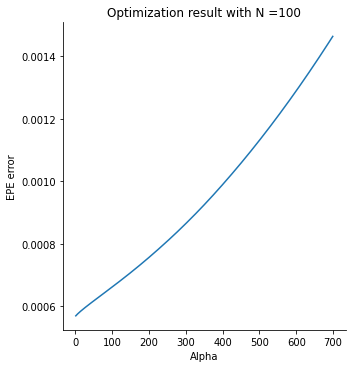

Best ang error mean : 0.01558626560247794 std : 0.06054951924874972
Best norm error mean : 0.00029941915529376996 std : 0.0016641124324510573
Best epe error  mean : 0.0005700596780912053 std : 0.0015918398103482523
Best alpha  = 1


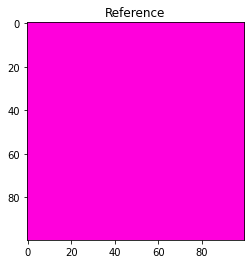

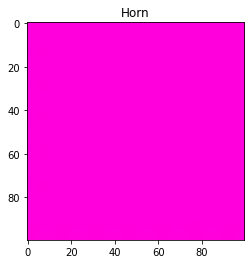

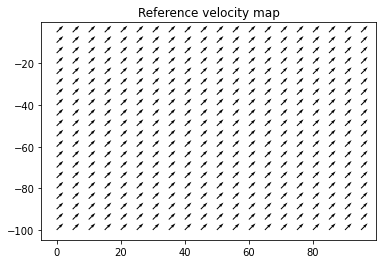

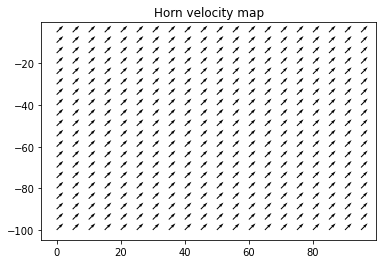

In [ ]:
# Horn
index = 0
REF = readflo(REFs[index])
run_horn(Imgs[index][0],Imgs[index][1], REF, optim=3)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

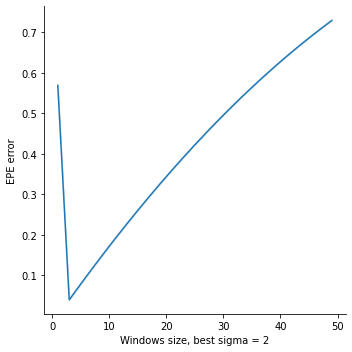

best sigma :  2
Best ang error mean : 2.1675957393777323 std : 10.674394713928086
Best norm error mean : 0.039600950943222475 std : 0.19501736856435647
Best epe error  mean : 0.03960629270404359 std : 0.19501628815421934
Best windows size  = 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


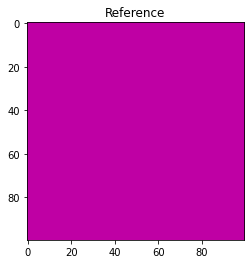

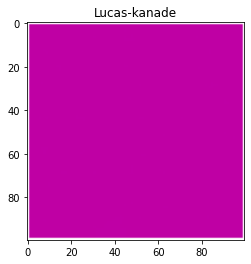

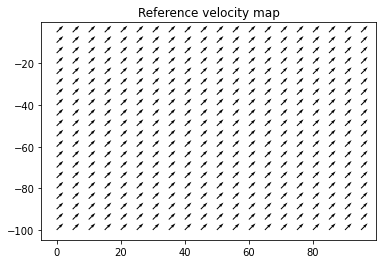

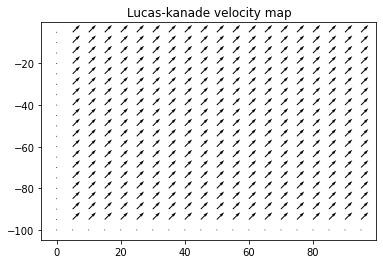

In [ ]:
# Lucas-Kanade
index = 0
REF = readflo(REFs[index])
run_kanade(Imgs[index][0],Imgs[index][1], REF, optim=3, sigma_min=1, sigma_max=5)

### Ruberwhale

../data/rubberwhale/correct_rubberwhale10.flo


  0%|          | 0/699 [00:00<?, ?it/s]

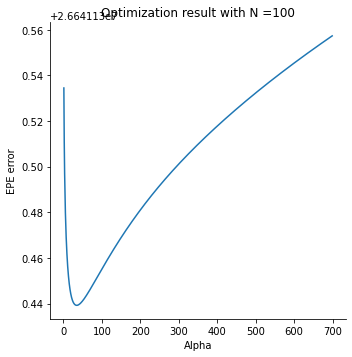

Best ang error mean : 11.957872931368666 std : 19.799655254654436
Best norm error mean : 26641130.224221632 std : 209026639.66150394
Best epe error  mean : 26641130.43920814 std : 209026639.744343
Best alpha  = 34


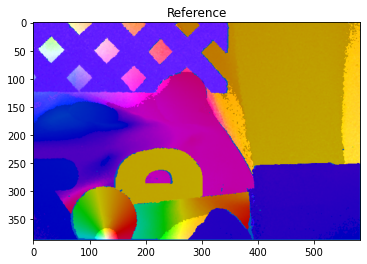

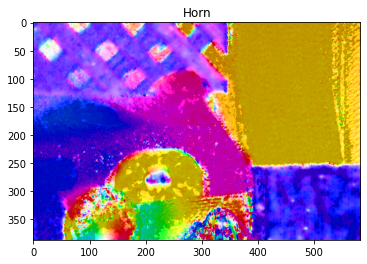

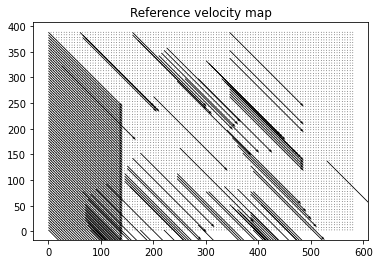

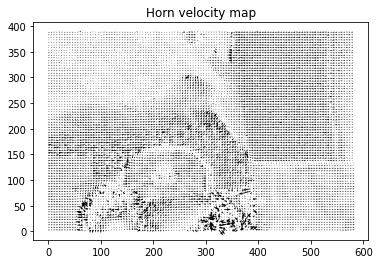

In [ ]:
# Horn
index = 1
REF = readflo(REFs[index])
print(REFs[index])
run_horn(Imgs[index][0],Imgs[index][1], REF, color=False, inv=False, optim=3)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

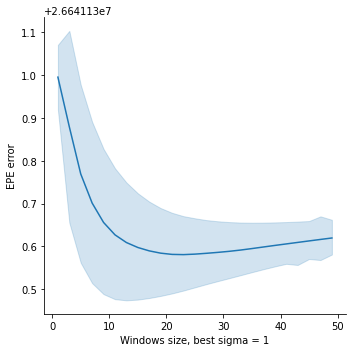

best sigma :  1
Best ang error mean : 12.14709995727873 std : 21.33014884511613
Best norm error mean : 26641129.587678067 std : 209026639.68244085
Best epe error  mean : 26641130.4184188 std : 209026639.7588433
Best windows size  = 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


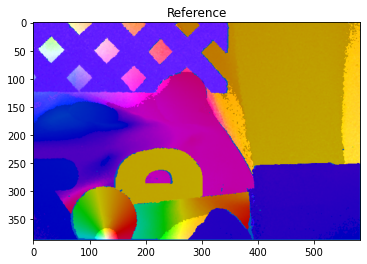

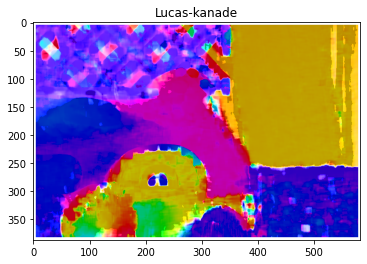

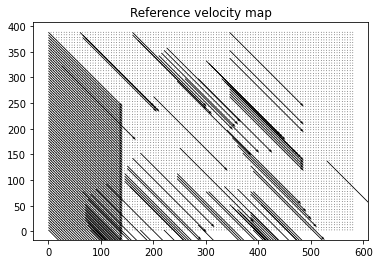

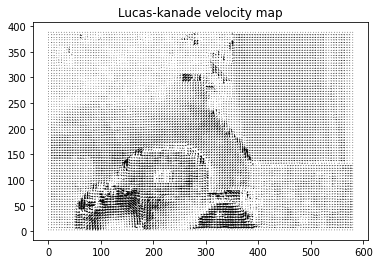

In [ ]:
# Lucas-Kanade
index = 1
REF = readflo(REFs[index])
run_kanade(Imgs[index][0],Imgs[index][1], REF, inv=False, optim=3, sigma_min=1, sigma_max=5)

### Square

  0%|          | 0/699 [00:00<?, ?it/s]

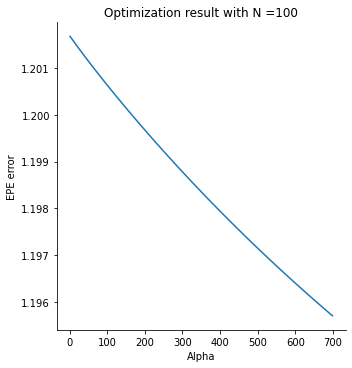

Best ang error mean : 53.38920241356038 std : 11.489206166747872
Best norm error mean : 1.1857274398054822 std : 0.2933698830206697
Best epe error  mean : 1.1956995777244346 std : 0.24991023743415322
Best alpha  = 699


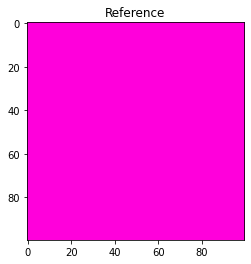

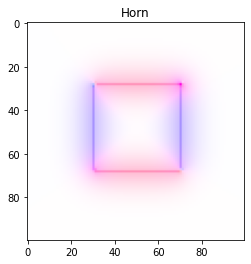

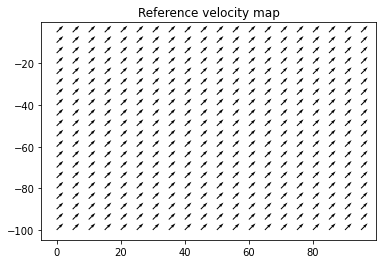

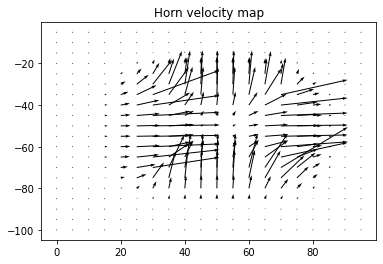

In [ ]:
# Horn
index = 2
REF = readflo(REFs[index])
run_horn(Imgs[index][0],Imgs[index][1], REF, optim=3)

../data/square/correct_square.flo


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

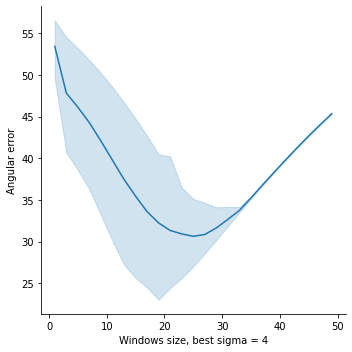

best sigma :  4
Best ang error mean : 20.450743481939718 std : 26.031066744560995
Best norm error mean : -3.613403497526708 std : 227.99599100464377
Best epe error  mean : 0.4570943953555843 std : 0.5846665074047942
Best windows size  = 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


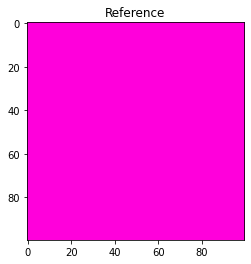

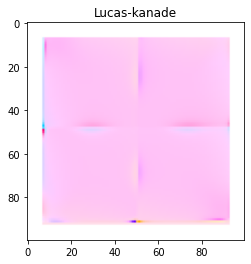

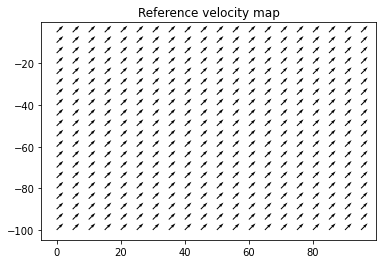

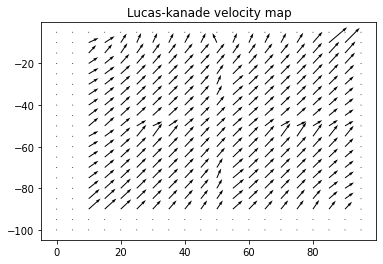

In [ ]:
# Lucas-Kanade
index = 2
REF = readflo(REFs[index])
print(REFs[index])
run_kanade(Imgs[index][0],Imgs[index][1], REF, color=True, optim=1, sigma_min=1, sigma_max=5)

### Yosemite

  0%|          | 0/699 [00:00<?, ?it/s]

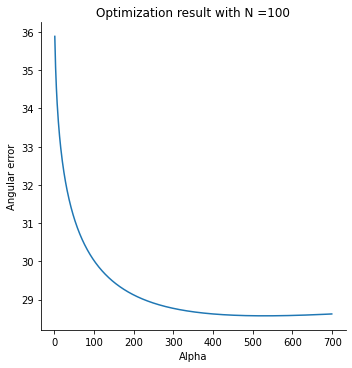

Best ang error mean : 28.576681091718545 std : 22.482139766763922
Best norm error mean : 0.2855451455189334 std : 1.0807924826408424
Best epe error  mean : 0.6601982954478179 std : 0.8439329764781277
Best alpha  = 530


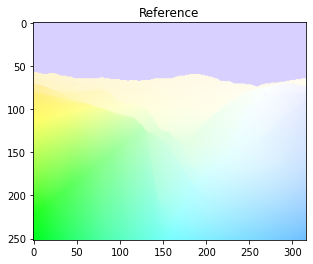

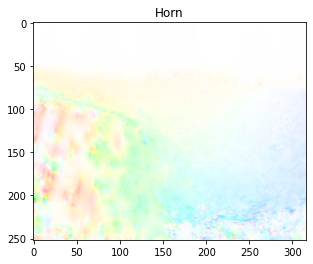

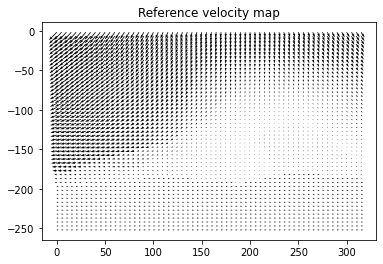

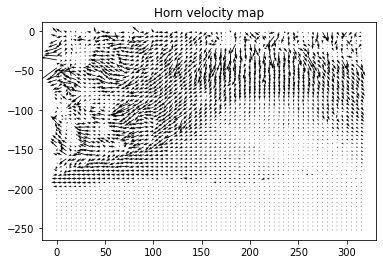

In [ ]:
# Horn
index = 3
REF = readflo(REFs[index])
run_horn(Imgs[index][0],Imgs[index][1], REF, optim=1)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

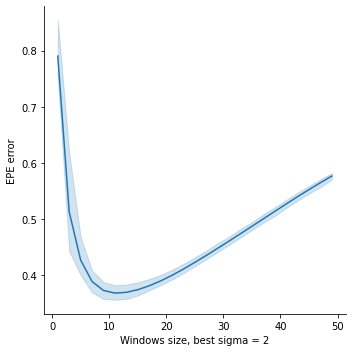

best sigma :  2
Best ang error mean : 19.512621873991748 std : 23.971098545984503
Best norm error mean : 0.02970556899141261 std : 1.352826923007677
Best epe error  mean : 0.3497124285593208 std : 0.5934929765990018
Best windows size  = 11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


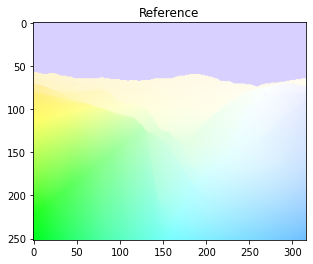

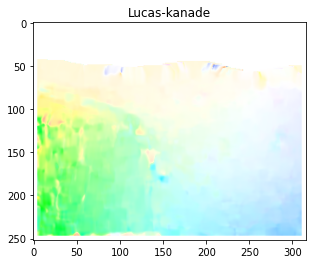

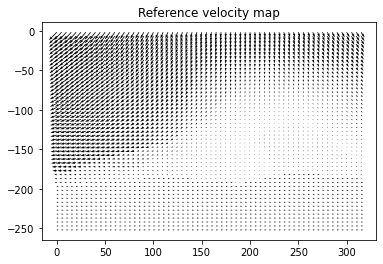

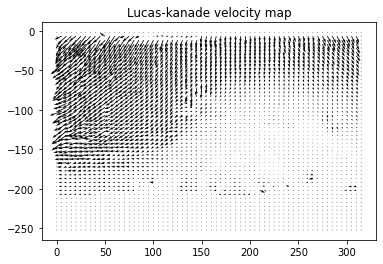

In [ ]:
# Lucas-Kanade
index = 3
REF = readflo(REFs[index])
run_kanade(Imgs[index][0],Imgs[index][1], REF, color=True, optim=3, sigma_min=1, sigma_max=5)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

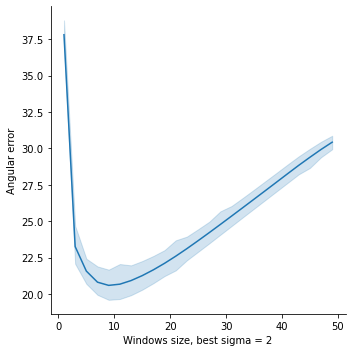

best sigma :  2
Best ang error mean : 19.512621873991748 std : 23.971098545984503
Best norm error mean : 0.02970556899141261 std : 1.352826923007677
Best epe error  mean : 0.3497124285593208 std : 0.5934929765990018
Best windows size  = 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:199: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


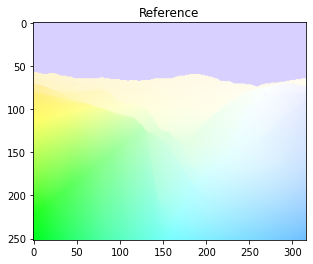

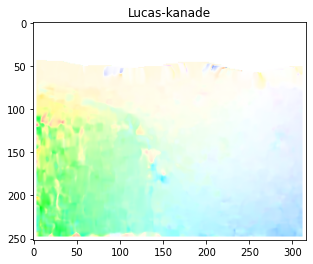

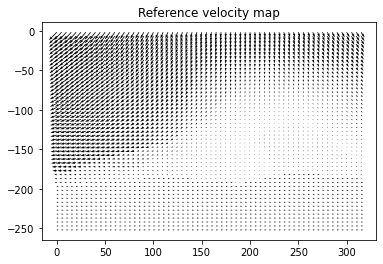

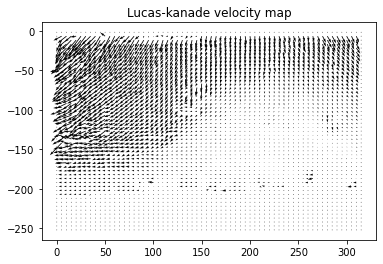

In [ ]:
# Lucas-Kanade
index = 3
REF = readflo(REFs[index])
run_kanade(Imgs[index][0],Imgs[index][1], REF, color=True, sigma_min=1, sigma_max=5)

### Test on non referenced images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


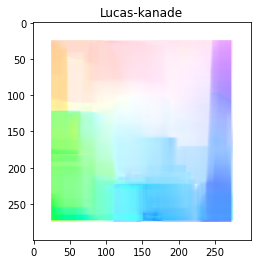

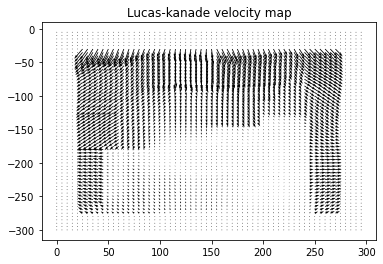

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


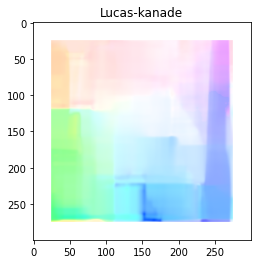

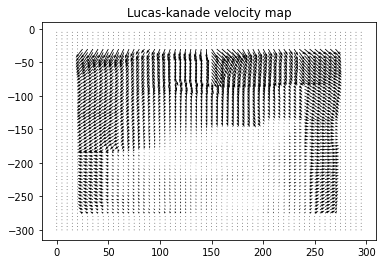

In [ ]:
ws=50
index=4
I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucas(I1, I2,ws)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 5)

I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucasG(I1, I2,ws,2)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:181: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


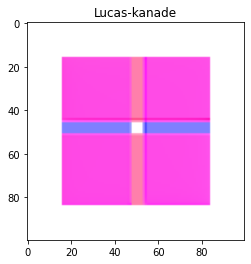

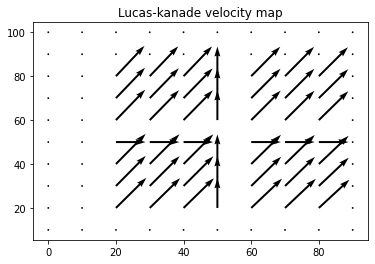

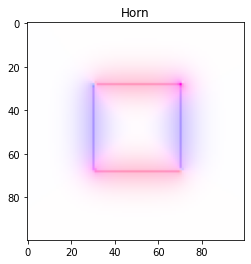

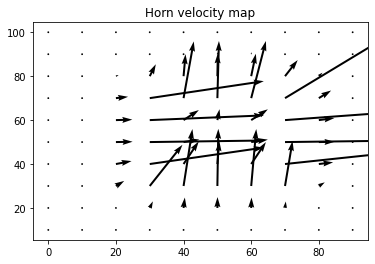

In [ ]:
ws=33
index=2
N=100
alpha=600

I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucas(I1, I2,ws)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 10, inv=False)

HS = horn(I1, I2, alpha, N)

plt.imshow(computeColor(HS.copy(), True))
plt.title('Horn')
plt.show()
    
quiver(HS, 'Horn velocity map', 10, inv=False)
#quiver(np.rot90(np.rot90(HS)), "Horn velocity map", 5, True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


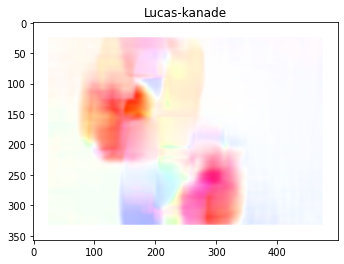

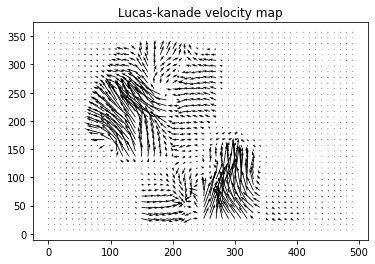

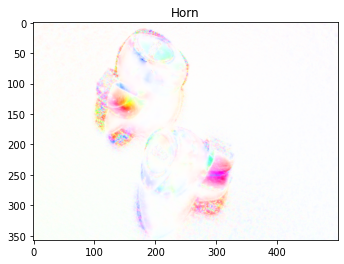

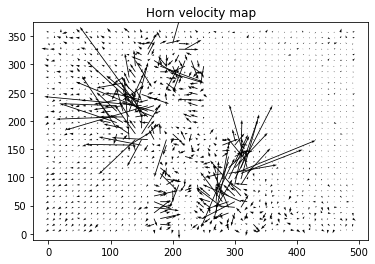

In [ ]:
ws=50
index=5
N=100
alpha=10

I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucasG(I1, I2,ws, 2)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 10, inv=False)

HS = horn(I1, I2, alpha, N)

plt.imshow(computeColor(HS.copy(), True))
plt.title('Horn')
plt.show()
    
quiver(HS, 'Horn velocity map', 10, inv=False)
#quiver(np.rot90(np.rot90(HS)), "Horn velocity map", 5, True)


Nasa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


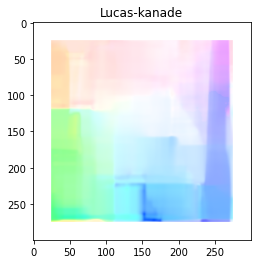

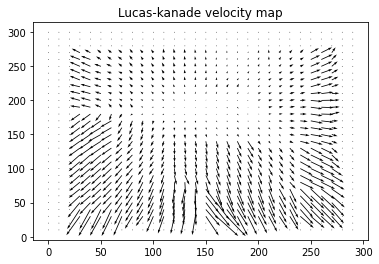

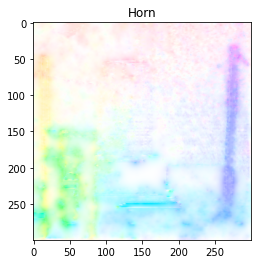

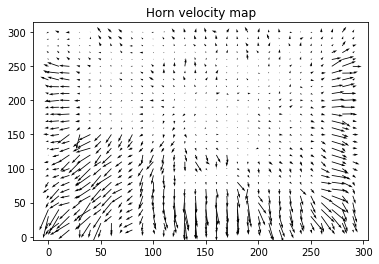

In [ ]:
ws=50
index=4
N=100
alpha=600
I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucasG(I1, I2,ws, 2)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 10, inv=False)

HS = horn(I1, I2, alpha, N)
plt.imshow(computeColor(HS.copy(), True))
plt.title('Horn')
plt.show()
    
quiver(HS, 'Horn velocity map', 10, inv=False)
#quiver(np.rot90(np.rot90(HS)), "Horn velocity map", 10, True)

Rubic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


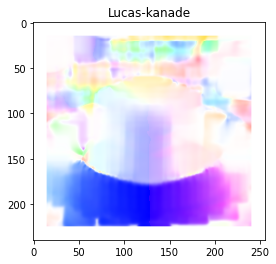

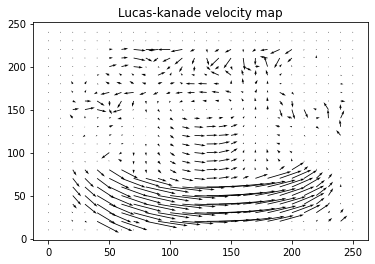

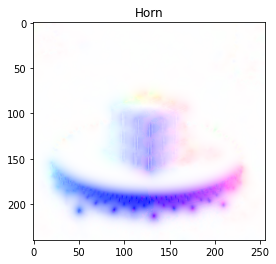

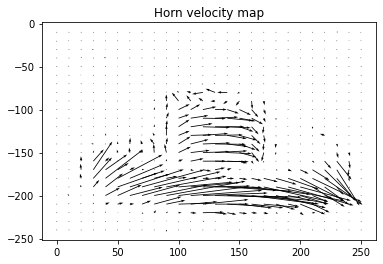

In [ ]:
ws=30
index=6
N=100
aplha=600

I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucasG(I1, I2,ws, 2)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 10, inv=False)

HS = horn(I1, I2, alpha, N)
plt.imshow(computeColor(HS.copy(), True))
plt.title('Horn')
plt.show()
    
quiver(np.rot90(np.rot90(HS)), "Horn velocity map", 10, True)

Taxi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


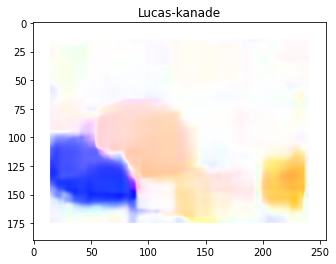

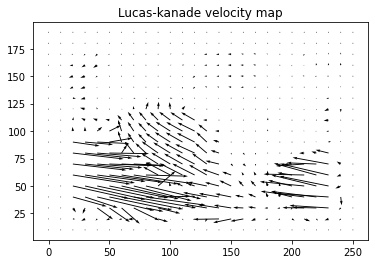

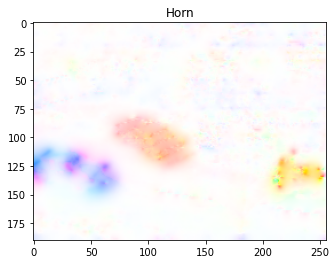

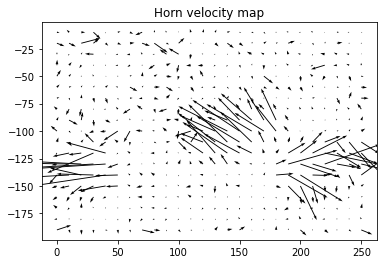

In [ ]:
ws=30
index=7
alpha = 600
N = 100

I1, I2 = [Imgs[index][0], Imgs[index][1]]
u,v= lucasG(I1, I2,ws, 2)
u_exp = np.expand_dims(u, axis=2)
v_exp = np.expand_dims(v, axis=2)
w = np.concatenate((u_exp,v_exp), axis=2)

plt.imshow(computeColor(w.copy(), True))
plt.title("Lucas-kanade")
plt.show()

quiver(w, 'Lucas-kanade velocity map', 10, inv=False)

HS = horn(I1, I2, alpha, N)
plt.imshow(computeColor(HS.copy(), True))
plt.title('Horn')
plt.show()
    
quiver(np.rot90(np.rot90(HS)), "Horn velocity map", 10, True)